# Polynomial Curve Fitting (from 1.1 but without using any packages)

Polynomial regression of synthetic data (sine wave + Gaussian noise).

Data obtained from http://research.microsoft.com/en-us/um/people/cmbishop/PRML/webdatasets/curvefitting.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [2]:
data = np.loadtxt('../data/curvefitting.txt', dtype=str, delimiter=' ')

In [3]:
data = data.astype(np.float64)

In [4]:
x = data[:, 0]
t = data[:, 1]

In [5]:
# for plotting the sinusoid
x_grid = np.linspace(0, 1, 100)
t_grid = np.sin(2 * np.pi * x_grid)

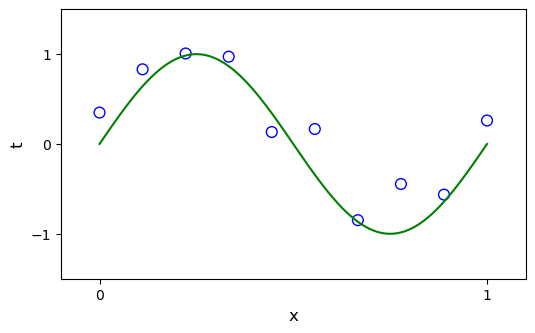

In [6]:
plt.figure(figsize=(6, 3.5))
plt.plot(x_grid, t_grid, 'g')  # ground truth sinusoid
plt.scatter(x, t, facecolors='none', edgecolors='b', s=60)
plt.xlim([-0.1, 1.1])
plt.ylim([-1.5, 1.5])
plt.xticks(ticks=[0, 1])
plt.yticks(ticks=[-1, 0, 1])
plt.xlabel('x', fontsize=12)
plt.ylabel('t', fontsize=12)
plt.show()

## Polynomial curve fitting

In [7]:
x.shape

(10,)

In [8]:
t.shape

(10,)

In [9]:
def create_design_matrix(x, deg):
    """create a design matrix for polynomial regression
    
    Args:
        x (np.array): observations (N, )
        deg (int): degree of polynomial
    
    Returns:
        Phi (np.array): design matrix in PRML (3.16), (N, M)
    """
    M = deg + 1  # M includes the bias term
    N = len(x)
    
    Phi = []
    for m in range(M):
        Phi.append(x ** m)
    Phi = np.array(Phi).T  # (N, M)
    
    return Phi

In [10]:
def create_design_matrix_2(x, deg):
    """create a design matrix for polynomial regression using broadcasting
    
    Args:
        x (np.array): observations (N, )
        deg (int): degree of polynomial
    
    Returns:
        Phi (np.array): design matrix in PRML (3.16), (N, M)
    """
    M = deg + 1  # M includes the bias term
    N = len(x)

    Phi = x[:, np.newaxis] ** np.arange(M)[np.newaxis, :]  # (N, 1) ** (1, M)
    
    return Phi

### Checking the design matrix

In [11]:
Phi = create_design_matrix(x, deg=1)
Phi

array([[1.      , 0.      ],
       [1.      , 0.111111],
       [1.      , 0.222222],
       [1.      , 0.333333],
       [1.      , 0.444444],
       [1.      , 0.555556],
       [1.      , 0.666667],
       [1.      , 0.777778],
       [1.      , 0.888889],
       [1.      , 1.      ]])

In [12]:
Phi.shape

(10, 2)

In [13]:
Phi_2 = create_design_matrix_2(x, deg=1)
Phi_2

array([[1.      , 0.      ],
       [1.      , 0.111111],
       [1.      , 0.222222],
       [1.      , 0.333333],
       [1.      , 0.444444],
       [1.      , 0.555556],
       [1.      , 0.666667],
       [1.      , 0.777778],
       [1.      , 0.888889],
       [1.      , 1.      ]])

In [14]:
Phi = create_design_matrix(x, deg=3)

In [15]:
Phi

array([[1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.111111  , 0.01234565, 0.00137174],
       [1.        , 0.222222  , 0.04938262, 0.0109739 ],
       [1.        , 0.333333  , 0.11111089, 0.03703693],
       [1.        , 0.444444  , 0.19753047, 0.08779123],
       [1.        , 0.555556  , 0.30864247, 0.17146818],
       [1.        , 0.666667  , 0.44444489, 0.29629674],
       [1.        , 0.777778  , 0.60493862, 0.47050795],
       [1.        , 0.888889  , 0.79012365, 0.70233222],
       [1.        , 1.        , 1.        , 1.        ]])

In [16]:
Phi_2 = create_design_matrix_2(x, deg=3)

In [17]:
np.allclose(Phi, Phi_2)

True

In [18]:
%%timeit -n 100
Phi = create_design_matrix(x, deg=100)

118 µs ± 9.09 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit -n 100
Phi = create_design_matrix_2(x, deg=100)

9.96 µs ± 2.83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Comparing two ways of solving the normal equation in (3.15)

In [20]:
A = Phi.T @ Phi
B = Phi.T @ t

In [21]:
%%timeit -n 1000
np.linalg.inv(A) @ B

3.77 µs ± 126 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
%%timeit -n 1000
np.linalg.solve(A, B)

2.5 µs ± 49.8 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [23]:
def solve_normal_equation(Phi, t):
    """solve the normal equation for linear reqression (3.15)
    
    Args:
        Phi (np.array): design matrix (N, M)
        t (np.array): target values (N, )
    
    Returns:
        w_ML (np.array): coefficients including the bias term (M + 1, )
    """
    A = Phi.T @ Phi
    B = Phi.T @ t
    w_ML = np.linalg.solve(A, B)  # faster and numerically more stable than np.linalg.inv
    
    return w_ML

In [24]:
def poly_fit(x, t, x_grid, deg):
    """
    Args:
        x (np.array): inputs (N, )
        t (np.array): target values (N, )
        x_grid (np.array): input values for making predictions (N_grid, )
        deg (int): degree of the polynomial
        
    Returns:
        t_pred (np.array): predicted values for x_grid (N_grid, )
        w_ML (np.array): coefficients (M, 1)
    """
    Phi = create_design_matrix(x, deg)
    w_ML = solve_normal_equation(Phi, t)
    
    Phi_2 = create_design_matrix(x_grid, deg)
    t_pred = Phi_2 @ w_ML
    
    return t_pred, w_ML

In [25]:
def plot_fit(x, t, x_grid, t_pred, ax, M):
    ax.scatter(x, t, facecolors='none', edgecolors='b', s=60)
    ax.plot(x_grid, t_grid , 'g')
    ax.plot(x_grid, t_pred, 'r')
    ax.text(x=0.8, y=0.9, s=f'M = {M}', fontsize=14) 
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-1.4, 1.4])
    ax.set_xticks(ticks=[0, 1])
    ax.set_yticks(ticks=[-1, 0, 1])
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('t', fontsize=12)

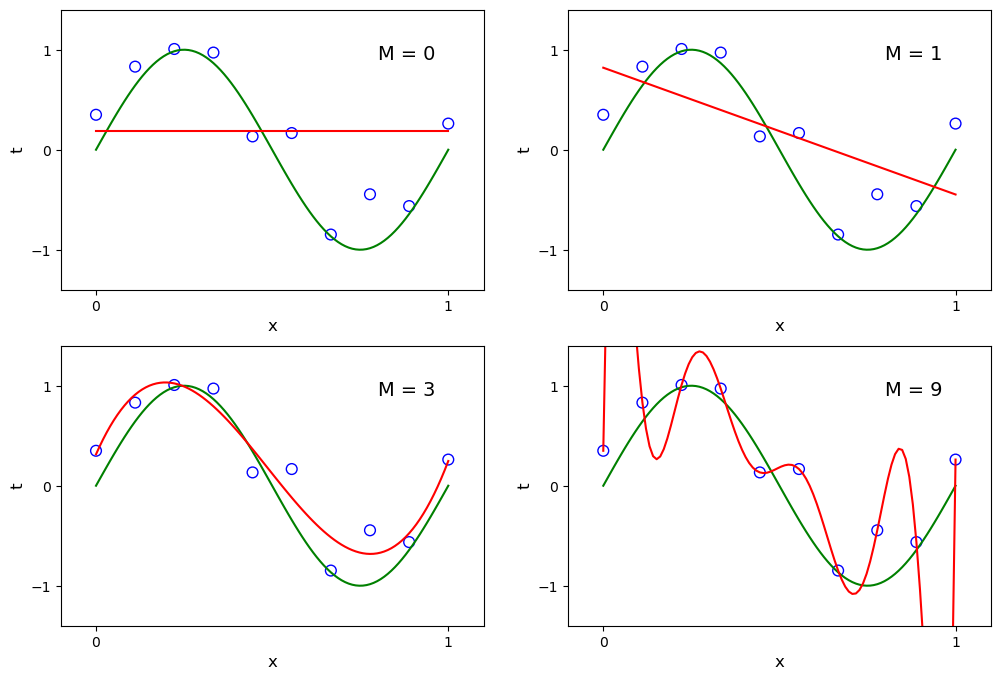

In [26]:
M_list = [0, 1, 3, 9]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax = axs.flatten()

for i, M in enumerate(M_list):
    t_pred, _ = poly_fit(x, t, x_grid, M)
    plot_fit(x, t, x_grid, t_pred, ax[i], M)

## Examine the coefficients (Table 1.1)

In [27]:
np.set_printoptions(precision=2)

In [28]:
def print_coefs(x, t, M):
    """
    Args:
        x (np.array, float): inputs
        t (np.array, float): target values
        M (int): degree of polynomial
    
    Returns:
        prints the coefficients
    """
    _, coef = poly_fit(x, t, x_grid, M)
    print('\n'.join([f'w{i}:  {c:.2f}' for i, c in enumerate(coef)]))

In [29]:
print_coefs(x, t, M=0)

w0:  0.19


In [30]:
print_coefs(x, t, M=1)

w0:  0.82
w1:  -1.27


In [31]:
print_coefs(x, t, M=3)

w0:  0.31
w1:  7.99
w2:  -25.43
w3:  17.37


In [32]:
print_coefs(x, t, M=9)

w0:  0.35
w1:  232.46
w2:  -5324.05
w3:  48588.33
w4:  -231733.32
w5:  640298.23
w6:  -1062219.32
w7:  1042806.03
w8:  -557897.51
w9:  125249.06
